In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
from childes_mi.utils.paths import PHONBANK_DFS, DATA_DIR
from childes_mi.utils.general import flatten

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
phone_df = pd.read_pickle(PHONBANK_DFS/'phone_df.pickle')

In [5]:
phone_df['n_phones'] = [len(list(flatten(i))) for i in phone_df.phones.values]

In [6]:
phone_df[:3]

,name,transcript_id,age,dataset,language,sex,phones,orthography,xml_loc,n_phones
0,0,020926,2.833,Providence,eng,male,"[[ˈhi, ˈhæ, rəs], [ˈhi, ˈhæ, rəs], [ˈkævəʔ, ˈp...","[[[can, I], have, this], [[can, I], have, this...",/mnt/cube/tsainbur/Projects/github_repos/child...,1772
0,0,030006,3.000,Providence,eng,male,"[[*, haʊ, ˈbaʊ, *, ɪ, ˈdeɪ, mætʃ], [deɪ, ˈmætʃ...","[[xxx, how, <a>bout, xxx, if, they, match], [t...",/mnt/cube/tsainbur/Projects/github_repos/child...,2277
0,0,011117,2.000,Providence,eng,male,"[[None], [None], [None], [hɪ, ˈmi], [ˈbu], [No...","[[xxx], [xxx], [xxx], [help, me], [bowl], [xxx...",/mnt/cube/tsainbur/Projects/github_repos/child...,561


In [7]:
phone_df.dataset.unique()

array(['Providence', 'Davis', 'Goad'], dtype=object)

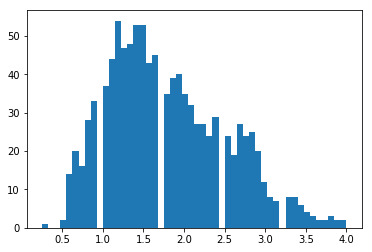

In [23]:
plt.hist(phone_df.age.values, bins = 50);

In [8]:
print("There are {} phones in this dataset".format(np.sum(phone_df.n_phones)))

There are 618583 phones in this dataset


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


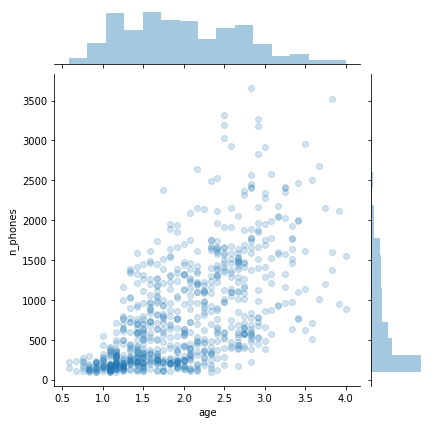

In [9]:
import seaborn as sns
sns.jointplot("age", "n_phones", data=phone_df[phone_df.n_phones > 100], alpha=0.2)

In [24]:
np.median(phone_df.n_phones)

306.0

## MI
- for each sequence, calculate the decay of a sequence as a function of distance between elements for that sequence indiividually
- Treat each phoneme as unique for that child, and compute MI across children

In [10]:
from childes_mi.information_theory import mutual_information as mi

#### Test run

In [11]:
distances = np.arange(1,101)

In [12]:
longest_row = phone_df.sort_values(by='n_phones', ascending=False).iloc[0]
phones_list = ''.join(flatten([i for i in flatten(longest_row.phones) if i is not None]))
(MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information([list(phones_list)], distances = distances)
print(phones_list[:10], len(np.unique(list(phones_list))))

*ɛˈbʊˈsɛvɪ 49


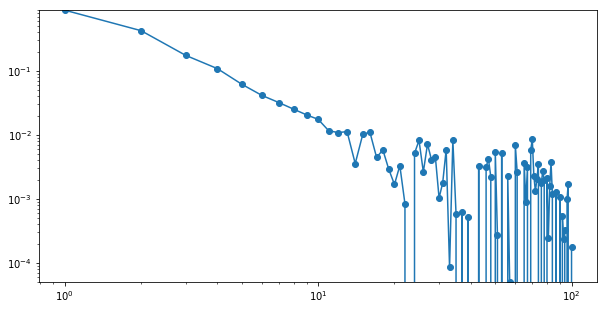

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(distances, MI-shuff_MI)
ax.plot(distances, MI-shuff_MI)
axmin = np.min((MI-shuff_MI)[(MI-shuff_MI) > 0])
axmax = np.max((MI-shuff_MI)[(MI-shuff_MI) > 0])
ax.set_ylim([axmin, axmax])
ax.set_yscale('log')
ax.set_xscale('log')

#### Run MI by age cohort

NameError: name 'transcript_df' is not defined

In [14]:
age_cohorts = [[0.5, 1], [1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3], [3, 20]]

In [15]:
mi_df = pd.DataFrame(
    columns=[
        "MI",
        "MI_var",
        "shuff_MI",
        "shuff_MI_var",
        "distances",
        "age_cohort_low",
        "age_cohort_high",
        "n_phones",
        "n_unique_phones",
    ]
)
# for each age cohort
for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts):
    cohort_subset = phone_df[
        (phone_df.age > age_cohort_low) & (phone_df.age <= age_cohort_high)
    ]

    cohort_phones = [
        [
            row.transcript_id + "_" + i
            for i in "".join(flatten([i for i in flatten(row.phones) if i is not None]))
        ]
        for idx, row in cohort_subset.iterrows()
    ]
    
    n_phones = len(np.concatenate(cohort_phones))
    n_unique_phones = len(np.unique(np.concatenate(cohort_phones)))

    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_phones, distances=distances, n_jobs=-1
    )

    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_phones,
        n_unique_phones,
    ]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:   10.3s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:   13.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:   10.9s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:   10.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:   40.4s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:   43.1s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   44.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:   30.8s remaining:   10.8s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:   30.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.0s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:   46.6s remaining:   16.4s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:   50.7s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   52.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:   43.8s remaining:   15.4s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:   44.2s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   45.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:   48.0s remaining:   16.9s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:   52.6s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   54.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:   50.2s remaining:   17.6s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:   53.6s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   55.0s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:   49.8s remaining:   17.5s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:   53.9s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   56.0s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:   47.9s remaining:   16.8s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:   53.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   54.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:   32.8s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:   36.0s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:   35.2s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:   36.2s remaining:    1.9s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.6s finished


In [18]:
mi_df.to_pickle(DATA_DIR / "mi" / "phonbank_mi.pickle")

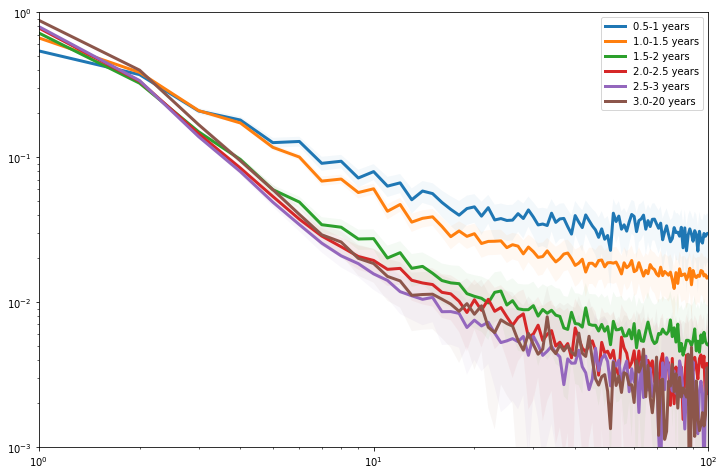

In [19]:
fig, ax = plt.subplots(figsize=(12,8))

for idx, row in mi_df.iterrows():
    MI = row.MI-row.shuff_MI
    MI_var = row.MI_var
    #ax.scatter(distances, row.MI-row.shuff_MI)
    ax.plot(distances, row.MI-row.shuff_MI, label = '{}-{} years'.format(row.age_cohort_low, row.age_cohort_high), lw=3)
    ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.05)
ax.legend()
ax.set_ylim([1e-3,1])
ax.set_xlim([1, 100])

ax.set_yscale('log')
ax.set_xscale('log')


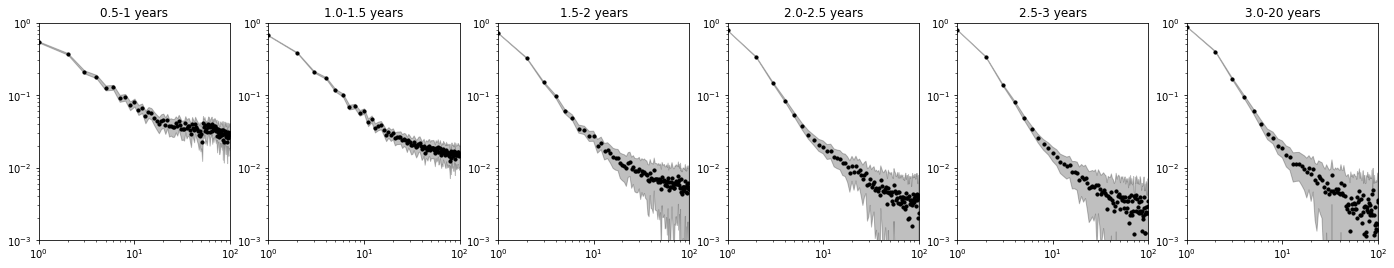

In [20]:
fig, axs = plt.subplots(ncols=len(mi_df), figsize=(4*len(mi_df),4))

for axi, (idx, row) in enumerate(mi_df.iterrows()):
    MI = row.MI-row.shuff_MI
    MI_var = row.MI_var
    #ax.scatter(distances, row.MI-row.shuff_MI)
    ax = axs[axi]
    #ax.plot(distances, row.MI-row.shuff_MI, label = '{}-{} years'.format(row.age_cohort_low, row.age_cohort_high), lw=3)
    ax.scatter(distances, row.MI-row.shuff_MI, s=10, color='k')
    ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
    #ax.legend()
    ax.set_title('{}-{} years'.format(row.age_cohort_low, row.age_cohort_high))
    ax.set_ylim([1e-3,1])
    ax.set_xlim([1, 100])

    ax.set_yscale('log')
    ax.set_xscale('log')
